# INFO 602 Final Project - InfoSec Open Source Intelligence (OSINT) Categorization
Michael Poff

## Executive Summary



In [1]:
import os
import warnings
import torch
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import string
from IPython.display import display, Markdown
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import *
from imblearn.pipeline import Pipeline
from sklearn.neural_network import *
from sklearn.naive_bayes import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sentence_transformers import SentenceTransformer
import numpy as np
import plotly_express as px
from sklearn.linear_model import *
import tiktoken
from openai import OpenAI
from transformers import pipeline

warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

## Data

In [2]:
data = pd.read_excel('./data/article_data.xlsx')[['content', 'category']]
display(Markdown(
    f"The dataset contains {len(data)} data points, each of which represents an article scraped from a number of information security news and intelligence providers (listed below). Each row contains the following features:"))

The dataset contains 345 data points, each of which represents an article scraped from a number of information security news and intelligence providers (listed below). Each row contains the following features:

### Data Dictionary   

- Title: The title of the article.
-   Content: The article contents.
-   Category: A manually labeled category label, chosen from one of nine options (listed below).
-   Zero-Shot Category: A label applied by the [HuggingFace zero-shot classification transformer](https://huggingface.co/tasks/zero-shot-classification) using the same set of nine options.
-   Zero-Shot Match: Indicates whether the zero-shot classification corresponds with the manual category assignment, expressed as TRUE or FALSE.

### Categories

**1. Vulnerability Reports**
Articles that detail specific software or hardware vulnerabilities, often including technical descriptions, severity assessments, and potential impact.

Classification Guidance:
-  Mentions of CVE identifiers (Common Vulnerabilities and Exposures).
-  Technical analysis or proof-of-concept code.
-  Discussions on vulnerability scores (e.g., CVSS scores).
-  Mention of affected platforms, software, or hardware.

**2. Security Updates and Patches**
These articles focus on the release of security updates, patches, or workarounds intended to fix vulnerabilities or improve security.

Classification Guidance:
-  Announcements from software or hardware vendors.
-  Instructions or recommendations for patching or updating systems.
-  Discussions of specific issues fixed by the update or patch.
-  References to advisory publications from vendors or security organizations.

**3. Emerging Threats and Attack Techniques**
Articles covering new or evolving cybersecurity threats, including novel attack vectors, malware, ransomware, or phishing campaigns.

Classification Guidance:
-  Descriptions of novel or evolving attack methodologies or exploit techniques.
-  Analysis of threat actors or campaigns.
-  Statistics or reports on the rise of specific threats.
-  Case studies or examples of recent attacks.
-  Focus on novel or evolving threat.
-  Novel research into system vulnerabilities without technical details or classifications (CVE).

**4. Regulatory Changes and Compliance**
Coverage of changes in cybersecurity laws, regulations, or standards, and how organizations can achieve compliance.

Classification Guidance:
-  Mention of specific legal acts, regulations, or compliance frameworks (e.g., GDPR, CCPA, HIPAA, SOC 2).
-  Guidance or advice on compliance strategies.
-  Analysis of the impact of regulatory changes on businesses or industries.
-  Expert commentary or interviews with legal or compliance professionals.

**5. Data Breaches and Security Incidents**
Reports on specific incidents where data has been exposed, stolen, or otherwise compromised, including details on the nature of the breach, affected parties, and aftermath. May be a breach or incident involving a wide-ranging scope (single company, to thousands of devices). Not every mention of an incident automatically classifies in this category, the distinction depends on the article's focus, depth of coverage regarding the specific incident, and the context in which the incident is mentioned.

Classification Guidance:
-  Specific details of the incident (what, when, how).
-  Information on the data compromised (types of data, number of records).
-  Responses or statements from the affected organization.
-  Analysis of the breach’s impact or lessons learned.
-  Specific details of an incident.

**6. News and Industry Updates**
General news related to the infosec industry, including market trends, mergers and acquisitions, or significant appointments and departures.

Classification Guidance:
-  Coverage of significant events or changes within infosec companies or organizations.
-  Market analysis or trends in cybersecurity.
-  Announcements of significant new technologies or products.
-  Profiles or interviews with industry leaders.
-  Specific government actions against individuals or groups.

**7. Marketing**
Articles or content primarily aimed at promoting specific cybersecurity products, services, or brands.

Classification Guidance:
-  Direct mentions of product features or benefits.
-  Comparisons with competing products or services.
-  Testimonials, case studies, or customer stories.
-  Content that focuses more on persuasion rather than providing objective information or analysis.

### Sources
-   [The Hacker News](https://thehackernews.com/)
-   [Bleeping Computer](https://www.bleepingcomputer.com/)
-   [Dark Reading](https://www.darkreading.com/)
-   [CISA Advisories](https://www.cisa.gov/news-events/cybersecurity-advisories)
-   [The Register - Security](https://www.theregister.com/security/)
-  [Cybersecurity Dive](https://www.cybersecuritydive.com/)

### Notes
The article data were scraped using the Python library [Trafilatura](https://github.com/adbar/trafilatura) which does a good job of scraping content and metadata from article web pages, however some results are skewed. Rather than manually refine the data, the model should learn to ignore this extraneous text.

## Preprocessing

This section tokenizes the contents of each article into words and sentences. Preprocessing on the data includes normalizing all content to lowercase, replacing common abbreviations that may be confused for stop words, removing URLs, removing punctuation, removing stop words, removing non-ascii characters, and [lemmatizing](https://en.wikipedia.org/wiki/Lemmatization) the words, and removing single character tokens. Finally, all words are joined into a single string and added as another feature in the dataset. 

Thanks to Afham Fardeen for his [guide](https://machinelearningknowledge.ai/11-techniques-of-text-preprocessing-using-nltk-in-python/) to performing text preprocessing.

In [3]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_lg')

# Add custom stop words
# Removing security, cybersecurity, and data to see if that improves model performance (worth noting after the fact that this didn't improve accuracy, but improved recall across the board by about 20%.
custom_stopwords = {'said', 'say', 'use', 'include', 'security', 'cybersecurity', 'data', 'datum'}
for word in custom_stopwords:
    nlp.Defaults.stop_words.add(word)

# Convert the data in the content column to lowercase
data['content'] = data['content'].str.lower()


# Perform sentence tokenization
def sentence_tokenize(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences


data['sentences'] = data['content'].apply(sentence_tokenize)


# Handle abbreviations in the data that align with stopwords
def replace_abbreviations(text):
    replacements = {'u.s.': 'usa', 'u.s': 'usa'}
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text


data['content'] = data['content'].apply(replace_abbreviations)


# Remove urls from the data
def remove_urls(text):
    # Regex pattern for matching URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Replace URLs with an empty string
    return re.sub(url_pattern, '', text)


# Apply the URL removal function before processing the text with spaCy
data['content'] = data['content'].apply(remove_urls)


def remove_punctuation_from_text(text):
    # Create a translation table where each punctuation mark is mapped to a space
    table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    # Use the translation table to replace punctuation with spaces in the text
    return text.translate(table)


data['content'] = data['content'].apply(remove_punctuation_from_text)


# Function to process text with spaCy, incorporating tokenization, stop word removal, lemmatization, and non-ASCII removal
def process_text(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_ascii and not token.is_punct:
            if token.lemma_.lower() == "datum":  # some instances of the word data were being lematized to datum and others were not, normalizing on the word data rather than datum.
                token.lemma_ = "data"

            tokens.append(token.lemma_.lower())
    return tokens


data['words'] = data['content'].apply(process_text)


# Remove tokens that are a single character long
def remove_short_tokens(text):
    result = []
    for word in text:
        if len(word) > 1:
            result.append(word)
    return result


data['words'] = data['words'].apply(remove_short_tokens)

data['processed_content'] = data['words'].apply(lambda x: ' '.join(x))

words = pd.DataFrame(data[['words', 'category']])
del data['words']

## Exploratory Data Analysis

### Data Preview
First, a quick look at a row of data. This is limited to a single row because the contents are quite large.

In [5]:
data.head(1).style.set_properties(**{'background-color': 'black',
                                     'color': 'white',
                                     'border-color': 'gray'})

,content,category,sentences,processed_content
0,the usa cybersecurity and infrastructure security agency cisa on wednesday added a high severity flaw impacting ios ipados macos tvos and watchos to its known exploited vulnerabilities kev catalog based on evidence of active exploitation the vulnerability tracked as cve 2022 48618 cvss score 7 8 concerns a bug in the kernel component an attacker with arbitrary read and write capability may be able to bypass pointer authentication apple said in an advisory adding the issue may have been exploited against versions of ios released before ios 15 7 1 the iphone maker said the problem was addressed with improved checks it s currently not known how the vulnerability is being weaponized in real world attacks interestingly patches for the flaw were released on december 13 2022 with the release of ios 16 2 ipados 16 2 macos ventura 13 1 tvos 16 2 and watchos 9 2 although it was only publicly disclosed more than a year later on january 9 2024 it s worth noting that apple did resolve a similar flaw in the kernel cve 2022 32844 cvss score 6 3 in ios 15 6 and ipados 15 6 which was shipped on july 20 2022 it s not immediately clear if the two vulnerabilities are related an app with arbitrary kernel read and write capability may be able to bypass pointer authentication the company said at the time a logic issue was addressed with improved state management in light of the active exploitation of cve 2022 48618 cisa is recommending that federal civilian executive branch fceb agencies apply the fixes by february 21 2024 the development also comes as apple expanded patches for an actively exploited security flaw in the webkit browser engine cve 2024 23222 cvss score 8 8 to include its apple vision pro headset the fix is available in visionos 1 0 2,vulnerability reports,"['the u.s. cybersecurity and infrastructure security agency (cisa) on wednesday added a high-severity flaw impacting ios, ipados, macos, tvos, and watchos to its known exploited vulnerabilities (kev) catalog, based on evidence of active exploitation.the vulnerability, tracked as cve-2022-48618 (cvss score: 7.8), concerns a bug in the kernel component.', '""an attacker with arbitrary read and write capability may be able to bypass pointer authentication,"" apple said in an advisory, adding the issue ""may have been exploited against versions of ios released before ios 15.7.1.""the iphone maker said the problem was addressed with improved checks.', ""it's currently not known how the vulnerability is being weaponized in real-world attacks.interestingly, patches for the flaw were released on december 13, 2022, with the release of ios 16.2, ipados 16.2, macos ventura 13.1, tvos 16.2, and watchos 9.2, although it was only publicly disclosed more than a year later on january 9, 2024.it's worth noting that apple did resolve a similar flaw in the kernel (cve-2022-32844, cvss score: 6.3) in ios 15.6 and ipados 15.6, which was shipped on july 20, 2022."", ""it's not immediately clear if the two vulnerabilities are related."", '""an app with arbitrary kernel read and write capability may be able to bypass pointer authentication,"" the company said at the time.', '""a logic issue was addressed with improved state management.', '""in light of the active exploitation of cve-2022-48618, cisa is recommending that federal civilian executive branch (fceb) agencies apply the fixes by february 21, 2024.the development also comes as apple expanded patches for an actively exploited security flaw in the webkit browser engine (cve-2024-23222, cvss score: 8.8) to include its apple vision pro headset.', 'the fix is available in visionos 1.0.2.']",usa infrastructure agency cisa wednesday add high severity flaw impact ios ipados macos tvo watchos known exploit vulnerability kev catalog base evidence active exploitation vulnerability track cve 2022 48618 cvs score concern bug kernel component attacker arbitrary read write capability able bypass pointer authenticat

### Categories
This is a simple count of how many articles there are per category.

In [6]:
data['category'].value_counts().reset_index()

,category,count
0,emerging threats and attack techniques,92
1,news and industry updates,91
2,data breaches and security incidents,47
3,marketing,33
4,regulatory changes and compliance,33
5,security updates and patches,29
6,vulnerability reports,20


### Word Clouds
These word clouds distill the core themes across different cybersecurity categories, highlighting key terms. They offer a quick visual summary of the most discussed topics in the field.

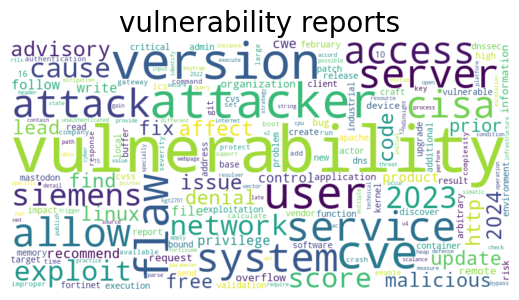

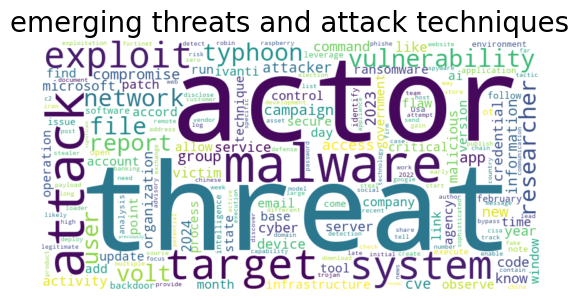

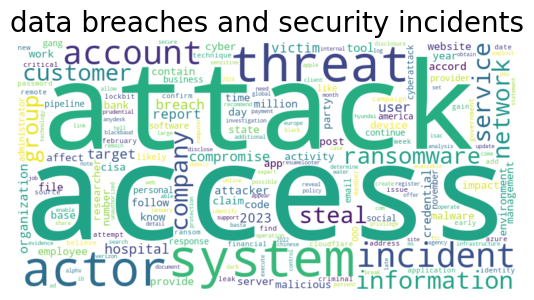

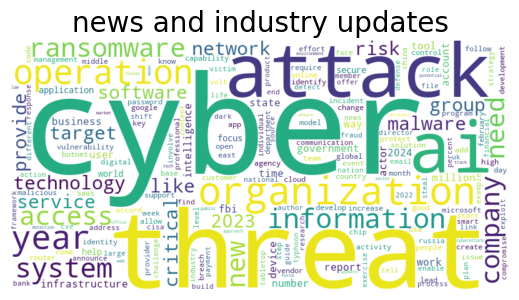

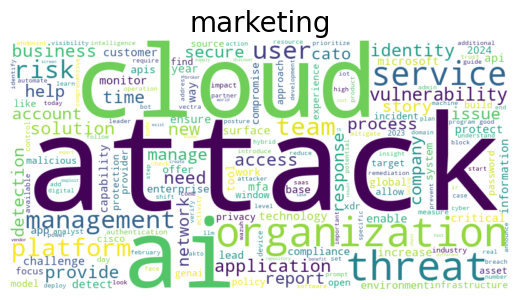

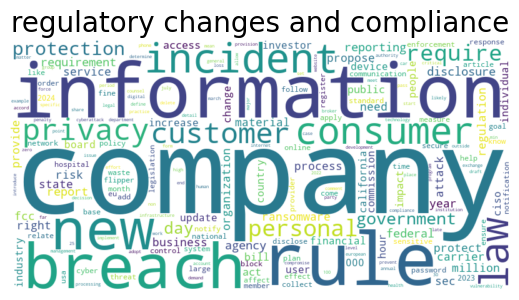

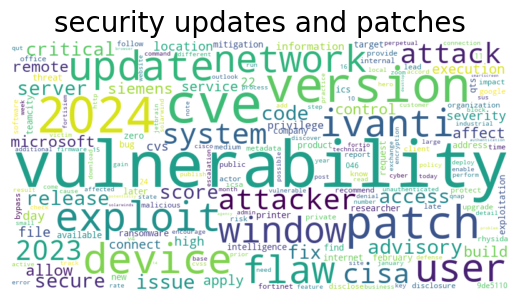

In [7]:
# Expand the list of words into a new row for each word
words_clean = words.explode('words').rename(columns={'words': 'word'})
words_clean = words_clean[words_clean['word'] != ""]  # Remove empty words

# Calculate word frequencies by category
word_frequencies_by_category = words_clean.groupby(['category', 'word']).size().reset_index(name='n')

# Iterate through each unique category to generate word clouds
for category in words_clean['category'].unique():
    # Filter data for the current category
    cat_data = word_frequencies_by_category[word_frequencies_by_category['category'] == category]

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
        dict(zip(cat_data['word'], cat_data['n'])))

    # Plotting the WordCloud                    
    plt.figure(figsize=(5, 2.5), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.title(category, fontsize=20)
    plt.show()

## Fitting Models

### Method 1: Zero Shot Classification



In [ ]:
%%capture
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

In [31]:
zdata = pd.DataFrame(data[['content', 'category']])

candidate_labels = ['vulnerability reports',
                    'security updates and patches',
                    'emerging threats and attack techniques',
                    'regulatory changes and compliance',
                    'data breaches and security incidents',
                    'news and industry updates',
                    'marketing']


def hf_zero_shot(sequence):
    classified_sequence = classifier(sequence, candidate_labels)
    classified_scores = {label: classified_sequence['scores'][classified_sequence['labels'].index(label)] for label in
                         candidate_labels if label in classified_sequence['labels']}
    category = max(classified_scores, key=classified_scores.get)

    return pd.Series([category, classified_scores])

zdata[['hf-zero-category', 'hf-zero-scores']] = zdata['content'].apply(hf_zero_shot)

prob_matrix = np.array(zdata['hf-zero-scores'].apply(lambda x: [x[label] for label in candidate_labels]).tolist())

# True labels are assumed to be in 'category' column of zdata_sub
true_labels = zdata['category'].tolist()

# Ensure true labels are encoded to match the candidate labels' order for log loss calculation
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(candidate_labels)
true_labels_encoded = label_encoder.transform(true_labels)



# Predicted labels for classification report
predicted_labels_encoded = np.argmax(prob_matrix, axis=1)
print(classification_report(true_labels_encoded, predicted_labels_encoded, target_names=candidate_labels))

# Calculate Log Loss
loss = log_loss(true_labels_encoded, prob_matrix, labels=range(len(candidate_labels)))
print(f"Cross-Entropy Loss / Log Loss: {loss}")

# Generate Confusion Matrix
cm = confusion_matrix(true_labels_encoded, predicted_labels_encoded)

# Plot Confusion Matrix
fig = px.imshow(
    cm, x=label_encoder.classes_,
    y=label_encoder.classes_, text_auto=True,
    aspect="auto",
    labels=dict(x="Predicted label", y="True label", color="Count"),
    color_continuous_scale='Blues',
    title='<b>Confusion Matrix</b>')
fig.show()



                                        precision    recall  f1-score   support

                 vulnerability reports       0.00      0.00      0.00         2
          security updates and patches       0.00      0.00      0.00         2
emerging threats and attack techniques       0.25      0.33      0.29         3
     regulatory changes and compliance       0.00      0.00      0.00         3
  data breaches and security incidents       0.50      0.33      0.40         3
             news and industry updates       0.00      0.00      0.00         0
                             marketing       0.00      0.00      0.00         3

                              accuracy                           0.12        16
                             macro avg       0.11      0.10      0.10        16
                          weighted avg       0.14      0.12      0.13        16

Cross-Entropy Loss / Log Loss: 2.324926014833328


In [24]:
#zdata_sub.head()
prob_matrix

array([[0.20010175, 0.07833903, 0.17914246, 0.15183726, 0.08309899,
        0.13048205, 0.17699845],
       [0.09543014, 0.03079946, 0.21084008, 0.04648603, 0.35160178,
        0.23408625, 0.03075629],
       [0.06444056, 0.03816004, 0.57423586, 0.01325137, 0.03596651,
        0.15543863, 0.11850709],
       [0.23646282, 0.10058384, 0.10732067, 0.14755389, 0.08143634,
        0.1505331 , 0.17610939],
       [0.13175882, 0.13013375, 0.22871429, 0.23934239, 0.09603822,
        0.11556797, 0.05844457],
       [0.01539161, 0.00715272, 0.18400338, 0.49447694, 0.04534474,
        0.23714185, 0.01648877],
       [0.0372362 , 0.01795881, 0.04971625, 0.37044457, 0.3930887 ,
        0.11890972, 0.01264575],
       [0.17138588, 0.08483796, 0.25029358, 0.09518638, 0.08195521,
        0.18890141, 0.12743954],
       [0.18191341, 0.01249347, 0.03141978, 0.22823162, 0.00885122,
        0.51407999, 0.02301048],
       [0.03105694, 0.0229921 , 0.09759405, 0.02132852, 0.07059675,
        0.73174775, 0.0

### Method 2: Bag of Words using TF-IDF
In this model pipeline, a series of steps are executed to pre-process the data, address class imbalance, and finally classify the data using a neural network.

1.  **Vectorization** *('vect', CountVectorizer())*: This first step uses a CountVectorizer to convert data['processed_content'] into a matrix of token counts by breacking the test into words (or tokens) and counting the occurence of each token in the dataset. The CountVectorizer focuses on the frequency of words used across documents.
2.  **Term Frequency Normalization** *('tfidf', TfidfTransformer(use_idf=False))*: After the initial vectorization step, the pipeline employs the TfidfTransformer without inverse document frequency (use_idf=False). This adjustment signifies that the transformer will not calculate the IDF values for each word across the documents. Without IDF, this step focuses on scaling the frequency of words withint each document to a standard range, ensuring that the length of the document does not disprpoportionately influence how it's understood or represented by the model.
3.  **Class Imbalance Handling** *('smote', SMOTE(random_state=42))*: The [SMOTE (Synthetic Minority Over-sampling Technique)](https://www.wikiwand.com/en/Oversampling_and_undersampling_in_data_analysis#SMOTE) step addresses class imbalance in the training data. Class imbalance can significantly affect the performance of machine learning models, leading to a bias towards the majority class; and as previously identified, this dataset suffers greatly from class imbalance. SMOTE generates synthetic samples from the minority class to create a balanced dataset, improving the classifier's ability to learn from an evenly distributed dataset.
4.  **Classification** *('clf', MLPClassifier(random_state=42))*: The final step in the pipeline employs an MLPClassifier, a type of neural network known as a Multi-Layer Perceptron. This classifier uses backpropagation for training, adjusting weights to minimize the error between predicted and actual classifications. The MLPClassifier is capable of capturing complex relationships in the data through its hidden layers, making it a powerful tool for classification tasks.

A fair bit of hyperparameter tuning took place, including the use of GridSearchCV to perform an exhaustive search for the best hyperparameter values given a range of values for each. The tables below show a range of models attempted along with hyperparameter tunings that gave the best results for each classifier.

These are the classifiers and hyperparameter settings that yielded the best accuracy and weighted precision for each classifier, ultimately MLPClassifier() and MultinomialNB(alpha=0.1) proved the best two.

MLPClassifier()
ComplementNB(alpha=0.1)
RandomForestClassifier(criterion="log_loss", random_state=42)
MultinomialNB(alpha=0.1)
GradientBoostingClassifier(max_depth=4, random_state=42) 


#### Results

In [ ]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    data['processed_content'],
    data['category'],
    test_size=.25,
    random_state=42,
    stratify=data['category']
)


# Build a function for fitting the model on different classifiers.
def bow_benchmark(clf):
    display(Markdown(f"{clf.__class__.__name__}"))

    # Model Pipeline
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('smote', SMOTE(random_state=42)),
        ('clf', clf),
    ])
    # Train the classifier
    text_clf.fit(X_train, y_train)

    # Evaluate the classifier
    predicted = text_clf.predict(X_test)
    predicted_probs = text_clf.predict_proba(X_test)
    predicted_probs = np.divide(predicted_probs, np.sum(predicted_probs, axis=1)[:, np.newaxis])
    print(classification_report(y_test, predicted))
    loss = log_loss(y_test, predicted_probs)
    print(f"Cross-Entropy Loss / Log Loss: {loss}")

    cm = confusion_matrix(y_test, predicted)

    fig = px.imshow(
        cm, x=clf.classes_,
        y=clf.classes_, text_auto='d',
        aspect="auto",
        labels=dict(
            x="predicted label", y="true label",
            color="cases"),
        color_continuous_scale='pubugn',
        title=f'<b>Confusion matrix:</b> {clf.__class__.__name__}', height=550)

    fig.show()


for clf in {
    (MLPClassifier(random_state=42)),
    (MultinomialNB(alpha=0.001))
}:
    bow_benchmark(clf)

#### Evaluation

**Interpreting the Metrics**
The MultinomialNB classifier correctly identifies the category of articles 68% of the time. On average, when it predicts an article belongs to a specific category, it is correct 69% of the time. Furthermore, it successfully identifies 68% of all articles that actually belong to each category.

The MLPClassifier accurately determines the category of articles 72% of the time. When it predicts an article belongs to a specific category, it is correct approximately 74% of the time. Additionally, it successfully identifies around 72% of all articles that truly belong to each category.

**Comparison**
While these models both do a good job of classifying the articles, the MLPClassifier is approximately 5.88% better in terms of accuracy compared to the MultinomialNB classifier. The MultinomialNB was able to achieve a slightly higher precision on marketing, however, the MLPClassifier is better overall, and the deficiency in the marketing category may be solved by adding more data. Additionally, the confidence and reliability of the MLPClassifier's predictions are notably higher. This means that not only does it classify articles more accurately, but its estimates about how likely each article belongs to its predicted category are closer to reality, suggesting it makes its decisions with a better understanding of the actual risks of misclassification. Given these considerations, the MLPClassifier emerges as the superior choice for this task. Its blend of higher accuracy, balanced performance across categories, and more confident predictions make it the more robust and dependable model for classifying cybersecurity articles.

**Final Thoughts and Next Steps**
These models excel beyond zero-shot classification in accuracy, showing advancement in article categorization. Yet, to fully leverage their potential in real-world applications, further improvements in accuracy, precision, and recall are essential. Enhancing these metrics reduces the need for manual corrections and ensures reliable system performance for accurate content identification and categorization. 

With TF-IDF now seen as outdated for generating embeddings, modern techniques like Word2Vec or Sentence-BERT (SBERT) offer paths to greater accuracy. Word2Vec excels at analyzing word context within text but lacks in capturing sentence or paragraph-level meanings. SBERT, building on the BERT model, is designed for sentence and document-level embeddings, providing a deeper context understanding. This feature, combined with SBERT's efficiency and ease of integration, makes it the chosen method for our next model development, aiming at improving text classification and categorization tasks.
 
The decision to adopt SBERT is driven by its capability to comprehend the intricacies of sentences and documents, which is crucial for accurately categorizing articles. This approach aligns with our objective to enhance the model's performance in distinguishing between different types of content effectively. By utilizing SBERT's advanced embedding capabilities, we anticipate a significant improvement in our model's ability to classify articles with higher accuracy, precision, and recall.

### Method 3: Embeddings

#### Method 3.1: Sentence Embeddings using SBERT
In this refined model pipeline, we address some of the limitations inherent in the bag of words approach by leveraging the advanced capabilities of SBERT for sentence embeddings. Here's how we've structured this approach.

**Sentence Embeddings ('sbert_model', SentenceTransformer('multi-qa-mpnet-base-dot-v1'))**: Begin by transforming our data into rich, dense embeddings using SBERT. Unlike the CountVectorizer, which treats each word in isolation, SBERT understands the context around each word, capturing the subtleties of language more effectively.

We iterate over a selection of classifiers, comparing their performance to identify the most effective approach for our classification task. In this pipeline, we focus on MLPClassifier and Logistic Regression, leveraging the dense representations from SBERT to train these models. Similar to the first approach, we tested numerous classifiers and reported on the two most effective:

RandomForestClassifier(criterion='log_loss', max_depth=10),
MLPClassifier(random_state=42),
LogisticRegression(),
MLPClassifier(),
GradientBoostingClassifier(max_depth=4, random_state=42)

This method aims to transcend the limitations of traditional bag of words models by incorporating the advanced NLP capabilities of SBERT, setting the stage for more accurate and contextually aware text classification.

*Thanks to [Thomas Wong](https://towardsdatascience.com/easily-get-high-quality-embeddings-with-sentencetransformers-c61c0169864b) and [Mariya Mansurova](https://towardsdatascience.com/text-embeddings-comprehensive-guide-afd97fce8fb5) for their guidance on working with SBERT embeddings*

In [11]:
%%capture
sbert_model = SentenceTransformer('multi-qa-mpnet-base-dot-v1', device=device)

In [12]:
# Create a dataframe from the sentence tokens and categories
sdata = data[['sentences', 'category']]


def get_embeddings(sentences):
    """
    Get embeddings for a list of sentences.
    The final embeddings is the mean of all sentence embeddings.
    
    :param sentences: list of str. Input sentences.
    :return: np.array. The mean embeddings of the sentences.
    """
    # Ensure that the input is a list of sentences
    if not isinstance(sentences, list):
        raise ValueError("Input must be a list of sentences")

    # Encode the sentences using the model and calculate the mean embeddings
    return np.mean(sbert_model.encode(sentences), axis=0)


sdata['embeddings'] = sdata['sentences'].apply(get_embeddings)

In [13]:
X = np.stack(sdata['embeddings'].values)
y = sdata['category'].values

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.25,
    random_state=42,
    stratify=y
)


def embed_benchmark(clf):
    display(Markdown(clf.__class__.__name__))
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    predicted_probs = clf.predict_proba(X_test)
    predicted_probs = np.divide(predicted_probs, np.sum(predicted_probs, axis=1)[:, np.newaxis])
    print(classification_report(y_test, predicted))
    loss = log_loss(y_test, predicted_probs)
    print(f"Cross-Entropy Loss / Log Loss: {loss}")

    cm = confusion_matrix(y_test, predicted)

    fig = px.imshow(
        cm, x=clf.classes_,
        y=clf.classes_, text_auto='d',
        aspect="auto",
        labels=dict(
            x="predicted label", y="true label",
            color="cases"),
        color_continuous_scale='pubugn',
        title=f'<b>Confusion matrix:</b> {clf.__class__.__name__}', height=550)

    fig.show()


classifiers = {
    MLPClassifier(random_state=42),
    LogisticRegression(random_state=42)
}

for clf in classifiers:
    embed_benchmark(clf)

MLPClassifier

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.69      0.75      0.72        12
emerging threats and attack techniques       0.65      0.87      0.74        23
                             marketing       0.50      0.33      0.40         9
             news and industry updates       0.75      0.65      0.70        23
     regulatory changes and compliance       1.00      0.88      0.93         8
          security updates and patches       0.67      0.29      0.40         7
                 vulnerability reports       0.43      0.60      0.50         5

                              accuracy                           0.68        87
                             macro avg       0.67      0.62      0.63        87
                          weighted avg       0.69      0.68      0.67        87

Cross-Entropy Loss / Log Loss: 1.130955631207527


LogisticRegression

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.71      0.83      0.77        12
emerging threats and attack techniques       0.62      0.91      0.74        23
                             marketing       0.67      0.44      0.53         9
             news and industry updates       0.74      0.61      0.67        23
     regulatory changes and compliance       1.00      0.75      0.86         8
          security updates and patches       1.00      0.14      0.25         7
                 vulnerability reports       0.43      0.60      0.50         5

                              accuracy                           0.68        87
                             macro avg       0.74      0.61      0.62        87
                          weighted avg       0.72      0.68      0.66        87

Cross-Entropy Loss / Log Loss: 0.8509173228184368


##### Evaluation
**Interpreting the Metrics**
The MLPClassifier demonstrates an overall accuracy of 68%, indicating its capability to correctly classify articles more than two-thirds of the time. It presents a precision score averaging at 69%, signifying that when it predicts the category of an article, that prediction is correct approximately 69% of the time. Its recall score also averages at 68%, reflecting the proportion of actual positives correctly identified.

On the other hand, the Logistic Regression model shows a matching overall accuracy of 68%. However, it exhibits a slightly improved precision average of 72% and a marginally lower recall average of 61%. The precision score suggests that the Logistic Regression model's predictions are more reliable, but its recall score suggests it is less adept at identifying all relevant instances within each category.

**Comparison**
Both models achieve the same accuracy, yet the Logistic Regression model has a slightly higher precision. The Logistic Regression model also achieves lower cross-entropy loss (0.8518) compared to the MLPClassifier's loss (1.1307), indicating better performance in terms of the confidence in its predictions. While the MLPClassifier is more consistent across different categories, the Logistic Regression model excels in certain categories, such as regulatory changes and compliance, and security updates and patches, albeit with some limitations in identifying all cases, as reflected by its recall scores.

The discrepancy between the models is particularly evident in the 'security updates and patches' category, where the Logistic Regression model has perfect precision but significantly lower recall, suggesting that while it is highly accurate when it identifies an article in this category, it fails to identify many of them.

**Compared to Bag of Words**
The current analysis indicates that while SBERT embeddings hold promise for enhancing text classification models, the improvements are not uniform across different machine learning algorithms. The increase in precision without a corresponding increase in accuracy or recall may point towards the need for more advanced model architectures or ensemble methods that can fully leverage the potential of SBERT embeddings.

In conclusion, the MLPClassifier and Logistic Regression models using SBERT embeddings are on par with the previously utilized models in terms of accuracy but offer different advantages in precision and recall. Continued experimentation with model tuning and potentially incorporating additional contextual or structural features from the cybersecurity domain may yield further improvements in model performance.

**Final Thoughts and Next Steps**
Both models have room for improvement, especially in balancing the trade-off between precision and recall. The Logistic Regression model's superior precision suggests it could be more suitable when the cost of a false positive is high. However, its lower recall indicates that it might miss a considerable number of true positives, which could be critical in cybersecurity article categorization.

Further exploration of the models' parameters and the training dataset could yield improvements. For instance, adjusting the class weight in the Logistic Regression model might improve recall, and exploring more complex architectures or hyperparameters for the MLPClassifier could enhance its precision.

Additionally, incorporating ensemble methods that combine the strengths of both models may also be beneficial. An ensemble could potentially improve overall performance by leveraging the Logistic Regression model's precision for certain categories and the MLPClassifier's recall for others.

The use of SBERT embeddings is evidently a positive step towards improving the models' understanding of the text data. However, the models may benefit from further fine-tuning or from additional feature engineering to capture more nuances in the cybersecurity domain. Continual iterations and model refinements will be critical in advancing the classification system's performance to meet the demands of accurate content identification and categorization.

Ultimately, the weakness in this model is likely due to the lack of data and significant challenges presented by class imbalance. Further tuning on this dataset may yield minor increases in accuracy, recall, and precision; however the greatest benefit would be to incorporate domain and non-domain data into the model such as through fine-tuning an existing classification model, or leveraging large language models.  



#### Method 3.2: Document Embeddings with OpenAI

Here we perform the same steps as with SBERT classification, only this time using embeddings from OpenAI's 'text-embedding-3-large' model which provides a distinct advantage in terms of leveraging the vast, diverse dataset OpenAI has access to, incorporating broader linguistic patterns and nuances. Unlike SBERT, which optimizes BERT for generating sentence-level embeddings with a focus on enhancing performance and speed for specific NLP tasks, OpenAI's model benefits from a more generalized training approach. This allows it to capture a wider array of semantic relationships and contextual cues across different types of text, potentially offering more nuanced and comprehensive embeddings for complex texts such as cybersecurity articles. The same classifiers were tested from the SBERT method, although this method benefitted greatly from hyperparameter tuning whereas the default settings yielded the best results on SBERT. 

In [14]:
# Start by checking the number of tokens in our data to ensure no articles have too many tokens, the max tokens for OpenAIs text-embedding-3-small model is 8191.
cost_basis = 1000
cost_per_basis = .00013
oaidata = data[['content', 'category']]


def count_tokens_from_string(string: str, encoding_name: str = 'cl100k_base'):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


oaidata['tokens'] = oaidata['content'].apply(count_tokens_from_string)

x = np.array(oaidata['tokens'])

display(Markdown(
    f"The dataset has a mean token count of {round(x.mean(), 2)}. The largest token count for any individual article is {x.max()}. The total number of tokens is {x.sum()} which will cost ${round((x.sum() / cost_basis) * cost_per_basis, 2)}"))

The dataset has a mean token count of 885.06. The largest token count for any individual article is 7432. The total number of tokens is 305344 which will cost $0.04

None of our articles exceed 8191 tokens, so we can proceed with our full dataset.

In [15]:
# Subset the original content and create OpenAI embeddings. Save the embedded data to disk to avoid costs associated with re-processing.

embedding_model = "text-embedding-3-large"

OPENAI_API_KEY = ""  # DELETE BEFORE COMMIT!!!

client = OpenAI(
    api_key=OPENAI_API_KEY
)


def get_oai_embeddings(text):
    response = client.embeddings.create(
        model=embedding_model,
        input=[text]
    )
    return response.data[0].embedding  # Change this

# oaidata['embeddings'] = oaidata['content'].apply(get_oai_embeddings)  # This costs $, use only as needed
# oaidata.to_csv('./data/oaiData.csv')


In [16]:
embeddedData = pd.read_csv('./data/oaiData.csv')
embeddedData['embeddings'] = embeddedData['embeddings'].apply(eval).apply(np.array)

In [17]:
X = np.stack(embeddedData['embeddings'].values)
y = embeddedData['category'].values

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.25,
    random_state=42,
    stratify=y
)

classifiers = {
    MLPClassifier(random_state=42),
    LogisticRegression(class_weight='balanced', solver='newton-cholesky', n_jobs=-1, random_state=42),

}

for clf in classifiers:
    embed_benchmark(clf)

MLPClassifier

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.79      0.92      0.85        12
emerging threats and attack techniques       0.75      0.91      0.82        23
                             marketing       0.71      0.56      0.62         9
             news and industry updates       0.76      0.70      0.73        23
     regulatory changes and compliance       1.00      0.62      0.77         8
          security updates and patches       0.60      0.43      0.50         7
                 vulnerability reports       0.57      0.80      0.67         5

                              accuracy                           0.75        87
                             macro avg       0.74      0.70      0.71        87
                          weighted avg       0.76      0.75      0.74        87

Cross-Entropy Loss / Log Loss: 0.7255349050221034


LogisticRegression

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.77      0.83      0.80        12
emerging threats and attack techniques       0.77      0.87      0.82        23
                             marketing       0.70      0.78      0.74         9
             news and industry updates       0.79      0.65      0.71        23
     regulatory changes and compliance       0.83      0.62      0.71         8
          security updates and patches       0.50      0.43      0.46         7
                 vulnerability reports       0.57      0.80      0.67         5

                              accuracy                           0.74        87
                             macro avg       0.70      0.71      0.70        87
                          weighted avg       0.74      0.74      0.73        87

Cross-Entropy Loss / Log Loss: 1.2518426401677203


##### Evaluation
# CHANGE THIS!!! NUMBERS ALTERED IN REFACTOR!!!

**Interpreting the Metrics**
The utilization of OpenAI embeddings for classifying cybersecurity articles has yielded distinct results. With the MLPClassifier, we observed an accuracy of 67%, indicating that the model could correctly classify two-thirds of the articles. The precision and recall scores across various categories suggest that the model's ability to correctly predict the category of an article and its capability to capture all relevant instances within each category varies significantly. The Logistic Regression model, tailored with class weights and optimized solver settings, achieved a higher accuracy of 76%. This model not only improved in accurately classifying articles but also demonstrated enhanced precision and recall, indicating a balanced ability in both predicting correct categories and identifying all relevant instances.

The MLPClassifier exhibited a Log Loss of 0.824, while the Logistic Regression model showed a higher Log Loss of 1.294. The lower Log Loss for the MLPClassifier suggests that, despite its lower overall accuracy compared to the Logistic Regression model, it has a higher confidence in the predictions it makes. This discrepancy highlights an interesting aspect of model evaluation where a model with higher accuracy (Logistic Regression) may not always have the lowest uncertainty in its predictions. The Log Loss is particularly insightful for classification tasks as it penalizes not just incorrect predictions but also the confidence level associated with those predictions, providing a more nuanced view of the model's performance.

**Comparison**
Comparing the performance of the MLPClassifier and Logistic Regression models with OpenAI embeddings, the latter clearly outperforms the former in terms of accuracy, precision, and recall. The Logistic Regression model's higher precision and recall scores across most categories indicate a more robust and reliable classification, especially in key areas such as data breaches, marketing, and news updates. The difference in performance could be attributed to the Logistic Regression model's ability to better leverage the dense, high-quality embeddings provided by OpenAI, which capture nuanced semantic relationships more effectively than the MLPClassifier in this context.

**Compared to SBERT**
In both OpenAI and SBERT embeddings, Logistic Regression performed better than the MLPClassifier in classifying articles. Interestingly, applying the same hyperparameter tunings from the Logistic Regression in OpenAI to the SBERT model resulted in worse performance, which is why the hyperparameters are different between the two. The OpenAI embeddings perform better overall in weighted precision and recall, although the macro precision on the OpenAI embeddings is slightly worse compared to SBERT. Overall accuracy is 8 percent better using OpenAI embeddings. 

**Final Thoughts and Next Steps**
The exploration of OpenAI embeddings for article classification has demonstrated promising results, particularly with the Logistic Regression model. The OpenAI model using logistic regression has yielded the most effective model yet, although only performing marginally better than SBERT and Bag of Words. A potential next step could be to explore fine-tuning of the embedding model on domain-specific data to better capture the nuances of cybersecurity content.

Moreover, addressing the limitations observed in recall for certain categories, such as security updates and patches, would be crucial. Strategies such as data augmentation for underrepresented categories, advanced sampling techniques, or incorporating additional contextual features could help in balancing precision and recall, ensuring a more equitable model performance across all categories.

An interesting pattern has emerged across all classifiers and methods thus far, observed in the confusion matrices, where high concentration of misclassification occur in the two highest represented categories, 'news and industry updates' and 'emerging threats and attack techniques'. This further reinforces a weakness inherent in the dataset caused by class imbalance. It is likely all of these models would benefit from more data, specifically more data in underrepresented categories.